In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder

In [8]:
dataset=pd.read_csv("C:/Users/USER/.conda/modified_survey_data.csv")

In [9]:
X = dataset.drop('treatment', axis = 1)
y = dataset['treatment']

# **# PREPROCESSING- TRANSFORMATION OF CATEGORICAL VALUE TO NUMERICAL**

In [10]:
ct = ColumnTransformer ([('oe',OrdinalEncoder(),['Gender', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company',
                                                 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
                                                 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
                                                 'mental_vs_physical', 'obs_consequence' ])], remainder='passthrough')

In [11]:
X = ct.fit_transform(X)


In [12]:
le = LabelEncoder ()
y = le.fit_transform(y)

In [13]:
import joblib
joblib.dump(ct,'feature_values')

['feature_values']

# **SPLIT INTO TRAIN AND TEST**

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=49)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((872, 22), (375, 22), (872,), (375,))

In [43]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report,auc
from sklearn.neighbors import KNeighborsClassifier

# **# DEFINING MODEL**

In [47]:
model_dict = {}

model_dict['Logistic regression'] = LogisticRegression(solver='liblinear', random_state=49)
model_dict['kNN'] = KNeighborsClassifier()
model_dict['Support Vector Machine'] = SVC(random_state=49)
model_dict['Random Forest'] = RandomForestClassifier(random_state=49)
model_dict['Stacking'] = StackingClassifier(estimators=[
        ('rf', RandomForestClassifier(random_state=49)),
        ('knn', KNeighborsClassifier()),
        ('lr', LogisticRegression(solver='liblinear', random_state=49))
    ], final_estimator=SVC(random_state=49))

In [48]:
def model_test (X_train, X_test, y_train, y_test, model, model_name):
    model.fit(X_train,y_train)
    y_pred = model.predict (X_test)
    accuracy = accuracy_score (y_test,y_pred)
    print('***********{}**********'.format(model_name))
    print('Accuracy : {}'.format (accuracy))
    print()

In [26]:
import numpy as np

# Check for missing values in X_train
print(np.isnan(X_train).sum())

# Check for missing values in X_test
print(np.isnan(X_test).sum())


187
74


In [28]:
from sklearn.impute import SimpleImputer
import numpy as np

# Separate numerical and categorical features in X_train and X_test
numerical_mask = np.sum(np.isnan(X_train), axis=0) > 0
categorical_mask = ~numerical_mask

# Create imputers for numerical and categorical features
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values for numerical features
X_train[:, numerical_mask] = numerical_imputer.fit_transform(X_train[:, numerical_mask])
X_test[:, numerical_mask] = numerical_imputer.transform(X_test[:, numerical_mask])

# Impute missing values for categorical features
X_train[:, categorical_mask] = categorical_imputer.fit_transform(X_train[:, categorical_mask])
X_test[:, categorical_mask] = categorical_imputer.transform(X_test[:, categorical_mask])


# **# MODEL AND ACCURACY**

In [52]:
for model_name, model in model_dict.items ():
    model_test(X_train, X_test, y_train, y_test, model,model_name)

***********Logistic regression**********
Accuracy : 0.784

***********kNN**********
Accuracy : 0.6666666666666666

***********Support Vector Machine**********
Accuracy : 0.7413333333333333

***********Random Forest**********
Accuracy : 0.8186666666666667

***********Stacking**********
Accuracy : 0.8346666666666667



# **# **STACKING ACCURACY , CONFUSION MATRIX, ROC CURVE, CLASSIFICATION REPORT****

In [54]:
stc =  StackingClassifier(estimators=[
        ('rf', RandomForestClassifier(random_state=49)),
        ('knn', KNeighborsClassifier()),
        ('lr', LogisticRegression(solver='liblinear', random_state=49))
    ], final_estimator=SVC(random_state=49))
stc.fit (X_train,y_train)
pred_stc = stc.predict (X_test)
print ('Accuracy of Stacking=', accuracy_score (y_test,pred_stc))

Accuracy of Stacking= 0.8346666666666667


In [62]:
from sklearn.model_selection import RandomizedSearchCV
params_stc = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 50, num = 15)],
              'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
             }
abc_random = RandomizedSearchCV (random_state=49, estimator=stc, param_distributions = params_stc,n_iter =50,cv=5,n_jobs=-1)

In [63]:
params_stc

{'n_estimators': [1, 4, 8, 11, 15, 18, 22, 25, 29, 32, 36, 39, 43, 46, 50],
 'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04]}

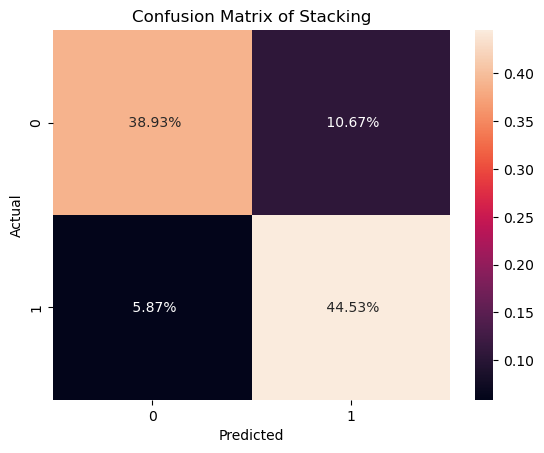

In [68]:
from sklearn.metrics import confusion_matrix

cm_stc = confusion_matrix(y_test, pred_stc)

sb.heatmap(cm_stc/np.sum(cm_stc), annot=True, fmt=' .2%')
plt.title('Confusion Matrix of Stacking')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


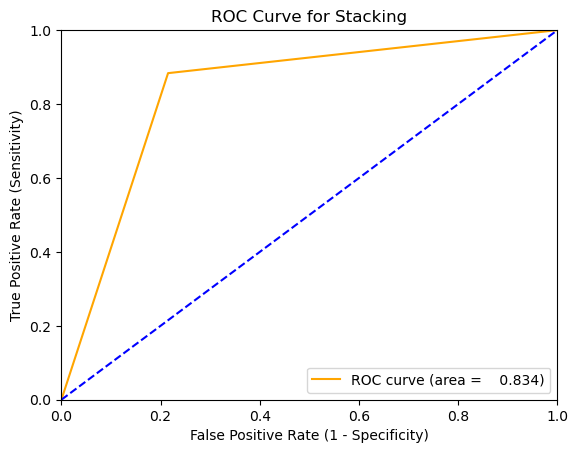

(array([0.        , 0.21505376, 1.        ]),
 array([0.        , 0.88359788, 1.        ]),
 array([2, 1, 0]))

In [94]:
from sklearn import metrics
fpr_abc, tpr_abc, thresholds_abc = roc_curve (y_test, pred_stc)
roc_auc_abc = metrics.auc(fpr_abc, tpr_abc)
plt.plot (fpr_abc, tpr_abc, color='orange', label= 'ROC curve (area = %8.3f)' % roc_auc_abc)
plt.plot ([0, 1], [0, 1], color='blue', linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.title('ROC Curve for Stacking')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel ('True Positive Rate (Sensitivity)' )
plt.legend(loc="lower right")
plt.show()
roc_curve(y_test,pred_stc)

In [70]:
print(classification_report(y_test,pred_stc))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       186
           1       0.81      0.88      0.84       189

    accuracy                           0.83       375
   macro avg       0.84      0.83      0.83       375
weighted avg       0.84      0.83      0.83       375



# **# kNN ACCURACY , CONFUSION MATRIX, ROC CURVE, CLASSIFICATION REPORT**

In [76]:
knnm =  KNeighborsClassifier()
knnm.fit (X_train,y_train)
pred_knn = knnm.predict (X_test)
print ('Accuracy of kNN=', accuracy_score (y_test,pred_knn))

Accuracy of kNN= 0.6666666666666666


In [78]:
from sklearn.model_selection import RandomizedSearchCV
params_knn = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 50, num = 15)],
              'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
             }
knn_random = RandomizedSearchCV (random_state=49, estimator=knnm, param_distributions = params_knn,n_iter =50,cv=5,n_jobs=-1)
params_knn

{'n_estimators': [1, 4, 8, 11, 15, 18, 22, 25, 29, 32, 36, 39, 43, 46, 50],
 'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04]}

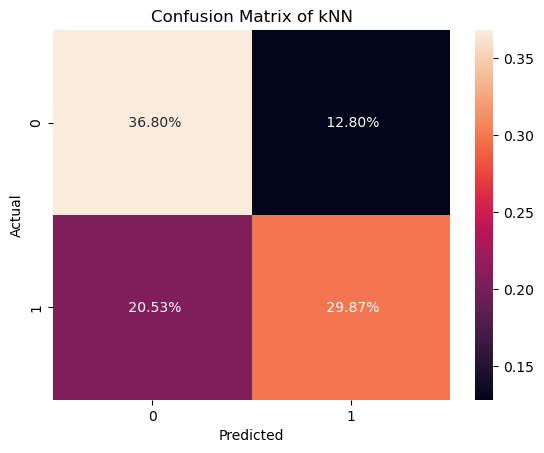

In [79]:
from sklearn.metrics import confusion_matrix
cm_knn = confusion_matrix(y_test, pred_knn)
sb.heatmap(cm_knn/np.sum(cm_knn), annot=True, fmt=' .2%')
plt.title('Confusion Matrix of kNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


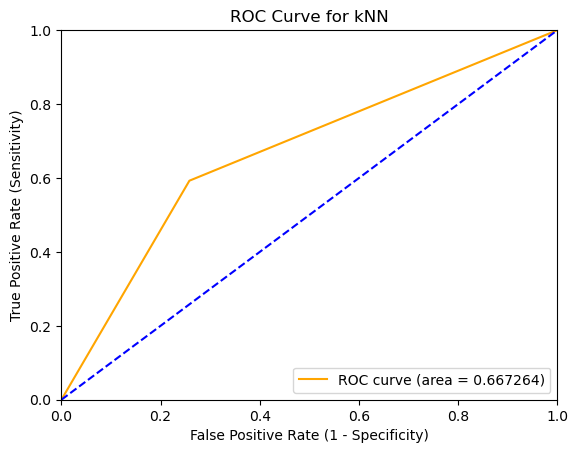

(array([0.        , 0.25806452, 1.        ]),
 array([0.        , 0.59259259, 1.        ]),
 array([2, 1, 0]))

In [93]:
from sklearn import metrics
fpr_abc, tpr_abc, thresholds_abc = roc_curve (y_test, pred_knn)
roc_auc_abc = metrics.auc(fpr_abc, tpr_abc)
plt.plot (fpr_abc, tpr_abc, color='orange', label= 'ROC curve (area = %6.6f)' % roc_auc_abc)
plt.plot ([0, 1], [0, 1], color='blue', linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.title('ROC Curve for kNN')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel ('True Positive Rate (Sensitivity)' )
plt.legend(loc="lower right")
plt.show()
roc_curve(y_test,pred_knn)

In [81]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.64      0.74      0.69       186
           1       0.70      0.59      0.64       189

    accuracy                           0.67       375
   macro avg       0.67      0.67      0.67       375
weighted avg       0.67      0.67      0.66       375



# **# LOGISTIC REGRESSION ACCURACY , CONFUSION MATRIX, ROC CURVE, CLASSIFICATION REPORT**

In [82]:
lrm =  LogisticRegression(solver='liblinear', random_state=49)
lrm.fit (X_train,y_train)
pred_lrm = lrm.predict (X_test)
print ('Accuracy of Logestic Regression=', accuracy_score (y_test,pred_lrm))


Accuracy of Logestic Regression= 0.784


In [83]:
from sklearn.model_selection import RandomizedSearchCV
params_lrm = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 50, num = 15)],
              'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
             }
lrm_random = RandomizedSearchCV (random_state=49, estimator=lrm, param_distributions = params_lrm,n_iter =50,cv=5,n_jobs=-1)
params_lrm

{'n_estimators': [1, 4, 8, 11, 15, 18, 22, 25, 29, 32, 36, 39, 43, 46, 50],
 'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04]}

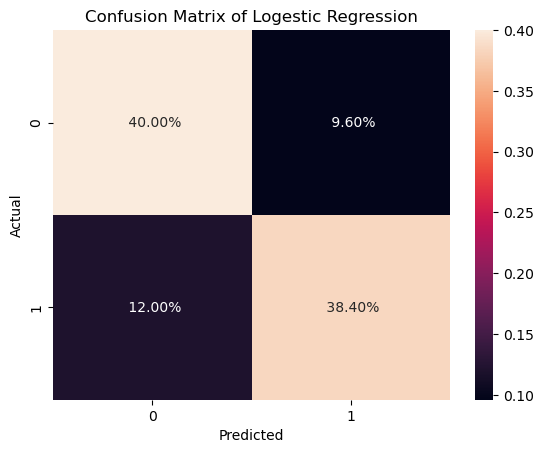

In [84]:
from sklearn.metrics import confusion_matrix
cm_lrm = confusion_matrix(y_test, pred_lrm)
sb.heatmap(cm_lrm/np.sum(cm_lrm), annot=True, fmt=' .2%')
plt.title('Confusion Matrix of Logestic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

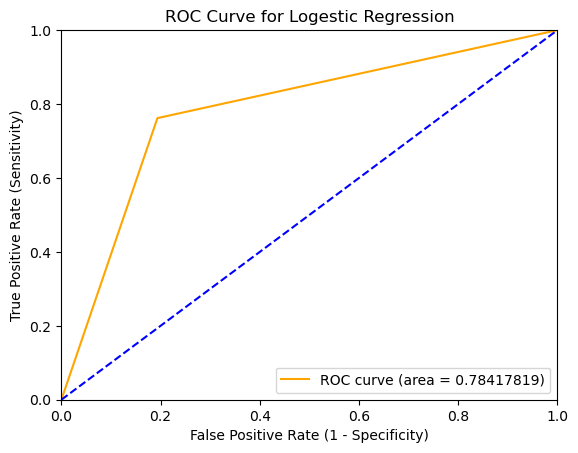

(array([0.        , 0.19354839, 1.        ]),
 array([0.        , 0.76190476, 1.        ]),
 array([2, 1, 0]))

In [95]:
from sklearn import metrics
fpr_abc, tpr_abc, thresholds_abc = roc_curve (y_test, pred_lrm)
roc_auc_abc = metrics.auc(fpr_abc, tpr_abc)
plt.plot (fpr_abc, tpr_abc, color='orange', label= 'ROC curve (area = %7.8f)' % roc_auc_abc)
plt.plot ([0, 1], [0, 1], color='blue', linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.title('ROC Curve for Logestic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel ('True Positive Rate (Sensitivity)' )
plt.legend(loc="lower right")
plt.show()
roc_curve(y_test,pred_lrm)


In [86]:
print(classification_report(y_test,pred_lrm))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       186
           1       0.80      0.76      0.78       189

    accuracy                           0.78       375
   macro avg       0.78      0.78      0.78       375
weighted avg       0.78      0.78      0.78       375



# **# RANDOM FOREST ACCURACY , CONFUSION MATRIX, ROC CURVE, CLASSIFICATION REPORT**

In [87]:
rfm =  RandomForestClassifier(random_state=49)
rfm.fit (X_train,y_train)
pred_rfm = rfm.predict (X_test)
print ('Accuracy of Random Forest=', accuracy_score (y_test,pred_rfm))

Accuracy of Random Forest= 0.8186666666666667


In [88]:
from sklearn.model_selection import RandomizedSearchCV
params_rfm = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 50, num = 15)],
              'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
             }
rfm_random = RandomizedSearchCV (random_state=49, estimator=rfm, param_distributions = params_rfm,n_iter =50,cv=5,n_jobs=-1)
params_rfm

{'n_estimators': [1, 4, 8, 11, 15, 18, 22, 25, 29, 32, 36, 39, 43, 46, 50],
 'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04]}

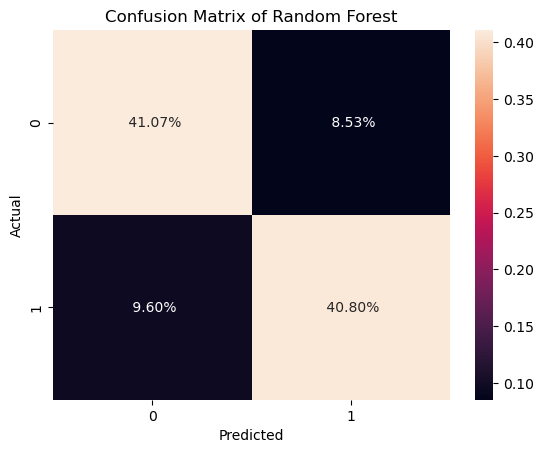

In [89]:
from sklearn.metrics import confusion_matrix
cm_rfm = confusion_matrix(y_test, pred_rfm)
sb.heatmap(cm_rfm/np.sum(cm_rfm), annot=True, fmt=' .2%')
plt.title('Confusion Matrix of Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

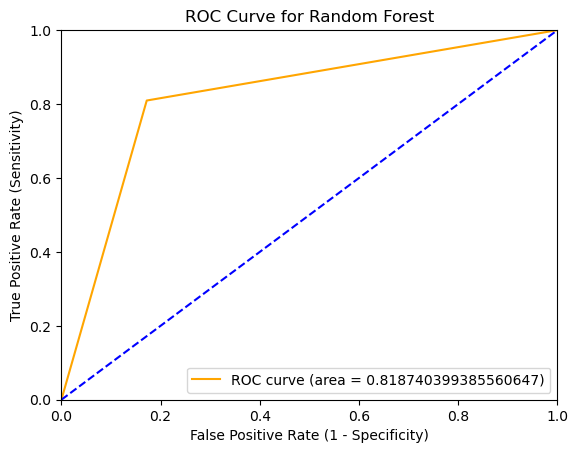

(array([0.        , 0.17204301, 1.        ]),
 array([0.        , 0.80952381, 1.        ]),
 array([2, 1, 0]))

In [96]:
from sklearn import metrics
fpr_abc, tpr_abc, thresholds_abc = roc_curve (y_test, pred_rfm)
roc_auc_abc = metrics.auc(fpr_abc, tpr_abc)
plt.plot (fpr_abc, tpr_abc, color='orange', label= 'ROC curve (area = %8.18f)' % roc_auc_abc)
plt.plot ([0, 1], [0, 1], color='blue', linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.title('ROC Curve for Random Forest')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel ('True Positive Rate (Sensitivity)' )
plt.legend(loc="lower right")
plt.show()
roc_curve(y_test,pred_rfm)


In [101]:
print(classification_report(y_test,pred_rfm))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       186
           1       0.83      0.81      0.82       189

    accuracy                           0.82       375
   macro avg       0.82      0.82      0.82       375
weighted avg       0.82      0.82      0.82       375



# **# SUPPORT VECTOR MACHINE ACCURACY , CONFUSION MATRIX, ROC CURVE, CLASSIFICATION REPORT**

In [97]:
svm = SVC(random_state=49)
svm.fit (X_train,y_train)
pred_svm = svm.predict (X_test)
print ('Accuracy of Support Vector Machine=', accuracy_score (y_test,pred_svm))

Accuracy of Support Vector Machine= 0.7413333333333333


In [98]:
from sklearn.model_selection import RandomizedSearchCV
params_svm = {'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 50, num = 15)],
              'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
             }
svm_random = RandomizedSearchCV (random_state=49, estimator=svm, param_distributions = params_svm,n_iter =50,cv=5,n_jobs=-1)
params_svm

{'n_estimators': [1, 4, 8, 11, 15, 18, 22, 25, 29, 32, 36, 39, 43, 46, 50],
 'learning_rate': [0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04]}

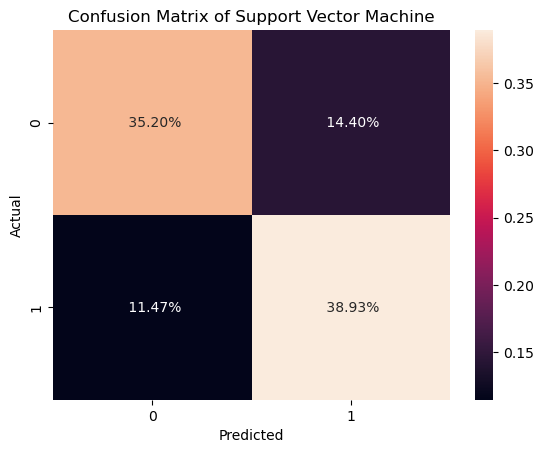

In [99]:
from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_test, pred_svm)
sb.heatmap(cm_svm/np.sum(cm_svm), annot=True, fmt=' .2%')
plt.title('Confusion Matrix of Support Vector Machine')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

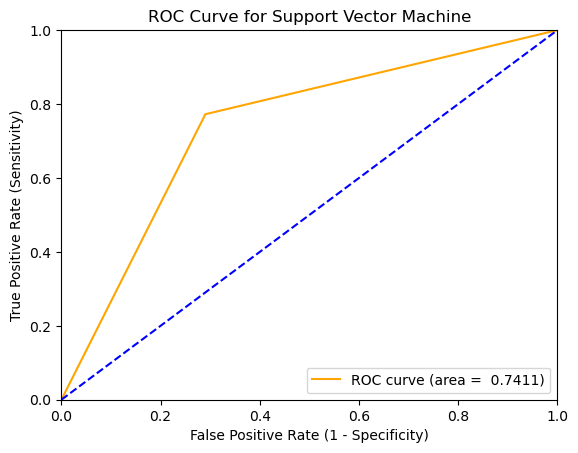

(array([0.        , 0.29032258, 1.        ]),
 array([0.        , 0.77248677, 1.        ]),
 array([2, 1, 0]))

In [100]:
from sklearn import metrics
fpr_abc, tpr_abc, thresholds_abc = roc_curve (y_test, pred_svm)
roc_auc_abc = metrics.auc(fpr_abc, tpr_abc)
plt.plot (fpr_abc, tpr_abc, color='orange', label= 'ROC curve (area = %7.4f)' % roc_auc_abc)
plt.plot ([0, 1], [0, 1], color='blue', linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 
plt.title('ROC Curve for Support Vector Machine')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel ('True Positive Rate (Sensitivity)' )
plt.legend(loc="lower right")
plt.show()
roc_curve(y_test,pred_svm)


In [102]:
print(classification_report(y_test,pred_svm))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       186
           1       0.73      0.77      0.75       189

    accuracy                           0.74       375
   macro avg       0.74      0.74      0.74       375
weighted avg       0.74      0.74      0.74       375

